In [1]:
import pandas as pd

In [8]:
import cv2
import os
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pvlib.iotools import read_tmy3
from matplotlib import rcParams


rcParams['figure.figsize'] = 20, 6
rcParams['lines.linewidth'] = 2.5

In [9]:
GHI_cs = pd.read_csv('/Users/yaizabermudez/internship/data_stage/Ineichen_clear_sky_model.csv', index_col='Unnamed: 0')[:'2022-10-01']

In [10]:
GHI_cs = GHI_cs.drop('dhi', axis = 1)
GHI_cs = GHI_cs.drop('dni', axis = 1)

In [11]:
GHI_cs

,ghi
2022-09-10 00:00:00-02:00,0.00000
2022-09-10 01:00:00-02:00,0.00000
2022-09-10 02:00:00-02:00,0.00000
2022-09-10 03:00:00-02:00,0.00000
2022-09-10 04:00:00-02:00,56.03764
...,...
2022-09-30 19:00:00-02:00,0.00000
2022-09-30 20:00:00-02:00,0.00000
2022-09-30 21:00:00-02:00,0.00000
2022-09-30 22:00:00-02:00,0.00000


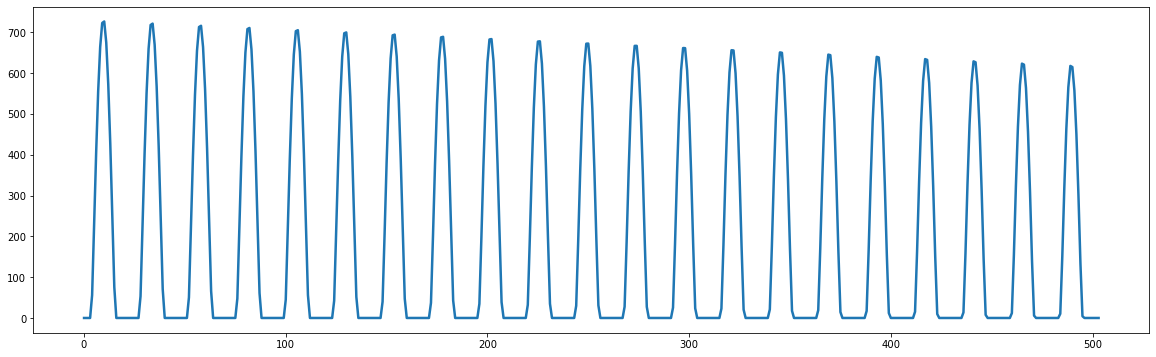

In [12]:
plt.plot(GHI_cs.values)
plt.show()

In [13]:
GHI_m = pd.read_csv('/Users/yaizabermudez/internship/data_stage/Rayonnement solaire-data-2023-06-13 09_46_08.csv', index_col='Time')[:'2022-10-01']

In [14]:
GHI_m.columns = ['ghi_m']

In [8]:
GHI_m

,ghi_m
Time,
2022-09-10 00:00:00,6.03
2022-09-10 01:00:00,6.97
2022-09-10 02:00:00,6.03
2022-09-10 03:00:00,6.97
2022-09-10 04:00:00,6.03
...,...
2022-09-30 19:00:00,16.30
2022-09-30 20:00:00,6.17
2022-09-30 21:00:00,6.00


In [9]:
new_index = pd.to_datetime(GHI_cs.index).tz_localize( None)
GHI_cs.index = new_index
GHI_m.index = new_index

In [10]:
GHI_cs

,ghi
2022-09-10 00:00:00,0.00000
2022-09-10 01:00:00,0.00000
2022-09-10 02:00:00,0.00000
2022-09-10 03:00:00,0.00000
2022-09-10 04:00:00,56.03764
...,...
2022-09-30 19:00:00,0.00000
2022-09-30 20:00:00,0.00000
2022-09-30 21:00:00,0.00000
2022-09-30 22:00:00,0.00000


In [11]:
neb =pd.read_csv("/Users/yaizabermudez/internship/data_stage/hybrid/data/neb.csv", index_col='Date')[:'2022-10-01']
neb

,nebulosity
Date,
2022-09-10 00:00:00,0.552006
2022-09-10 01:00:00,0.538226
2022-09-10 02:00:00,0.593627
2022-09-10 03:00:00,0.590393
2022-09-10 04:00:00,0.900041
...,...
2022-09-30 19:00:00,0.929318
2022-09-30 20:00:00,0.860587
2022-09-30 21:00:00,0.907851


In [12]:
GHI_cs/= 1000
GHI_m/=1000

In [13]:
print(GHI_cs.max(), GHI_m.max())

ghi    0.726355
dtype: float64 ghi_m    0.743
dtype: float64


In [14]:
GHI_cs.index = neb.index
GHI_m.index = neb.index

In [15]:
df = neb.copy()
df['ghi_m'] = GHI_m['ghi_m']
df['ghi_cs'] = GHI_cs['ghi']

In [16]:
X_test = df.values.reshape(len(df.values), 1,3)

In [49]:
import keras.backend as K
# n1 =6.42

def custom_mse(y_pred):
    # print(y_pred)
    a, n1 = y_pred

    # a = 0.51
    # n1_ =tf.cast(n1, float)

 
    # calculating squared difference between target and predicted values 
    diff = K.square(GHI_m['ghi_m'].to_numpy() - (1- (a * K.pow(neb, n1)))* GHI_cs['ghi'].to_numpy())
    loss = K.sum(diff)
    # loss /= len(diff)
    # loss = K.mean(diff)
    return loss

In [50]:
def create_model():
    inputs = keras.Input(shape=(1,3))
    x = keras.layers.Dense(24, activation='relu')(inputs)
    x = keras.layers.Dense(24, activation='relu')(x)
    x = keras.layers.Dense(24, activation='relu')(x)
    x = keras.layers.Dense(24, activation='relu')(x)
    output1 = keras.layers.Dense(1)(x)
    output2 = keras.layers.Dense(1)(x)

    model = keras.Model(inputs, [output1, output2], name="encoder")
    return model

In [51]:
model = create_model()

Manual training

In [52]:
def loss(model, x, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  # y_ = model(x, training=training)
  
  y_ = model(x, training=training)

  return custom_mse(y_pred=y_)

l = loss(model, X_test, training=False)
print("Loss test: {}".format(l))

Loss test: 11893344.0


In [53]:
def grad(model, inputs):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [55]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 50

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x in X_test:
    x = x.reshape(-1,1,3)
    # Optimize the model
    loss_value, grads = grad(model, x)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    print('loss :', loss_value)

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    # epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  # train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

loss : tf.Tensor(23167.104, shape=(), dtype=float32)
loss : tf.Tensor(19511.607, shape=(), dtype=float32)
loss : tf.Tensor(15844.36, shape=(), dtype=float32)
loss : tf.Tensor(14988.879, shape=(), dtype=float32)
loss : tf.Tensor(21232.264, shape=(), dtype=float32)
loss : tf.Tensor(15230.434, shape=(), dtype=float32)
loss : tf.Tensor(14670.988, shape=(), dtype=float32)
loss : tf.Tensor(16178.524, shape=(), dtype=float32)
loss : tf.Tensor(15993.176, shape=(), dtype=float32)
loss : tf.Tensor(15095.186, shape=(), dtype=float32)
loss : tf.Tensor(15186.679, shape=(), dtype=float32)
loss : tf.Tensor(14980.452, shape=(), dtype=float32)
loss : tf.Tensor(15059.991, shape=(), dtype=float32)
loss : tf.Tensor(14930.643, shape=(), dtype=float32)
loss : tf.Tensor(14805.857, shape=(), dtype=float32)
loss : tf.Tensor(15102.043, shape=(), dtype=float32)
loss : tf.Tensor(14686.51, shape=(), dtype=float32)
loss : tf.Tensor(14690.87, shape=(), dtype=float32)
loss : tf.Tensor(15548.413, shape=(), dtype=float

KeyboardInterrupt: 

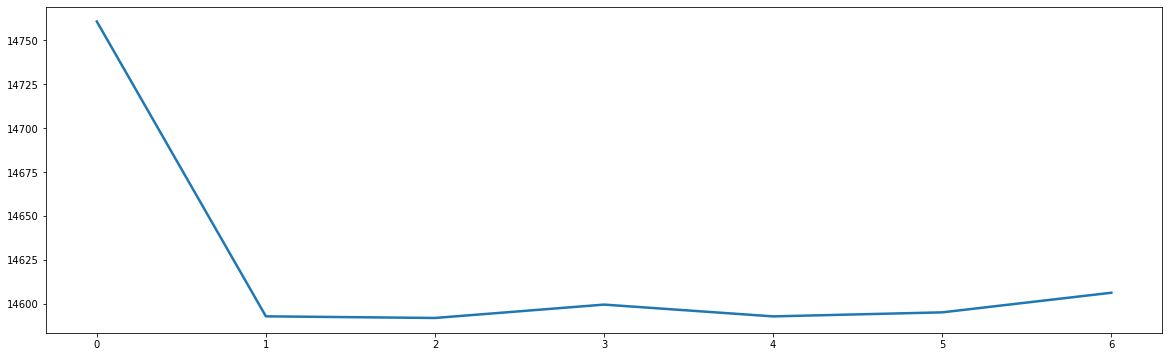

In [56]:
plt.plot(train_loss_results)
plt.show()

In [57]:
pred  = model.predict(X_test)

16/16 [==============================] - 0s 1ms/step


In [58]:
pred[1]

array([[[-3.42745334e-04]],

       [[-3.44671309e-04]],

       [[-3.33528966e-04]],

       [[-3.32713127e-04]],

       [[-1.62590295e-04]],

       [[-7.22974539e-04]],

       [[-5.46198338e-04]],

       [[-1.18295476e-03]],

       [[-1.47694722e-03]],

       [[-1.15982816e-03]],

       [[-1.47694722e-03]],

       [[-1.35628134e-03]],

       [[-1.11514330e-03]],

       [[-7.18045980e-04]],

       [[-2.21241266e-04]],

       [[ 4.22149897e-04]],

       [[ 1.68729573e-04]],

       [[ 1.66997313e-04]],

       [[ 1.91651285e-04]],

       [[-3.83220613e-05]],

       [[-3.04881483e-04]],

       [[-3.28194350e-04]],

       [[-3.35801393e-04]],

       [[-2.70891935e-04]],

       [[-3.27561051e-04]],

       [[-4.19501215e-04]],

       [[-3.47740948e-04]],

       [[-2.71931291e-04]],

       [[-3.38304788e-04]],

       [[-1.05510280e-03]],

       [[-1.08810514e-03]],

       [[-1.47694722e-03]],

       [[-1.47694722e-03]],

       [[-1.47694722e-03]],

       [[-1.29

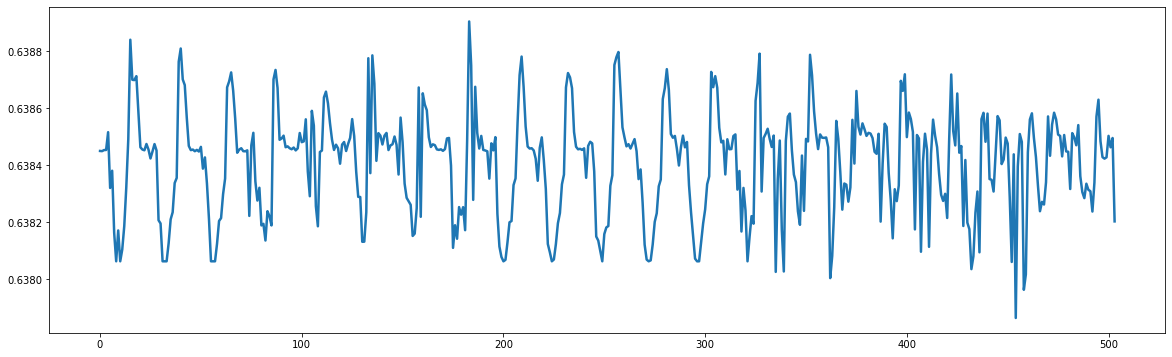

In [60]:
plt.plot(pred[0].flatten(), label = 'a')

No handles with labels found to put in legend.


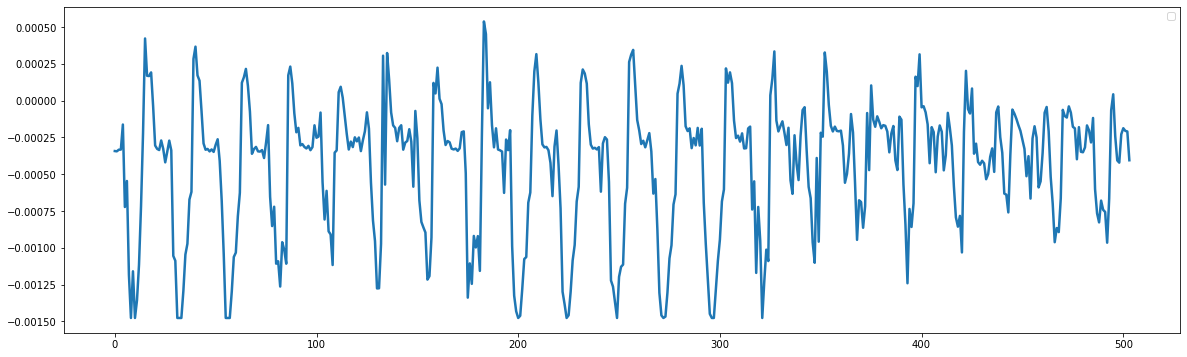

In [61]:

plt.plot(pred[1].flatten())
plt.legend()
plt.show()

In [62]:
pred_ = ((1-pred[0][0]*np.power(neb, pred[0][1]))[' nebulosity']*GHI_cs['ghi'])*1000

In [63]:
true = GHI_m['ghi_m']*1000

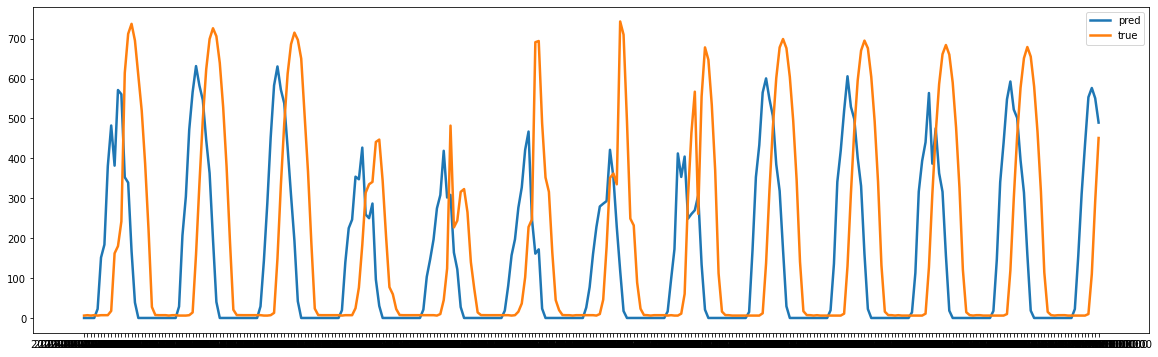

In [65]:
plt.plot(pred_[:300], label = 'pred')
plt.plot(true[:300], label = 'true')
plt.legend()
plt.show()


In [75]:
GHI_cs = pd.read_csv('/Users/yaizabermudez/internship/data_stage/Ineichen_clear_sky_model.csv', index_col='Unnamed: 0')['2022-11-01': '2022-12-25']

In [76]:
GHI_cs = GHI_cs.drop('dhi', axis = 1)
GHI_cs = GHI_cs.drop('dni', axis = 1)

In [77]:
GHI_cs

,ghi
2022-11-01 00:00:00-02:00,0.0
2022-11-01 01:00:00-02:00,0.0
2022-11-01 02:00:00-02:00,0.0
2022-11-01 03:00:00-02:00,0.0
2022-11-01 04:00:00-02:00,0.0
...,...
2022-12-24 19:00:00-02:00,0.0
2022-12-24 20:00:00-02:00,0.0
2022-12-24 21:00:00-02:00,0.0
2022-12-24 22:00:00-02:00,0.0


In [78]:
GHI_m = pd.read_csv('/Users/yaizabermudez/internship/data_stage/Rayonnement solaire-data-2023-06-13 09_46_08.csv', index_col='Time')['2022-11-01': '2022-12-25']

In [79]:
GHI_m.columns = ['ghi_m']

In [80]:
GHI_m

,ghi_m
Time,
2022-11-01 00:00:00,6.00
2022-11-01 01:00:00,6.00
2022-11-01 02:00:00,6.00
2022-11-01 03:00:00,6.98
2022-11-01 04:00:00,7.00
...,...
2022-12-24 19:00:00,142.00
2022-12-24 20:00:00,142.00
2022-12-24 21:00:00,142.00


In [81]:
new_index = pd.to_datetime(GHI_cs.index).tz_localize( None)
GHI_cs.index = new_index
GHI_m.index = new_index

In [82]:
GHI_cs

,ghi
2022-11-01 00:00:00,0.0
2022-11-01 01:00:00,0.0
2022-11-01 02:00:00,0.0
2022-11-01 03:00:00,0.0
2022-11-01 04:00:00,0.0
...,...
2022-12-24 19:00:00,0.0
2022-12-24 20:00:00,0.0
2022-12-24 21:00:00,0.0
2022-12-24 22:00:00,0.0


In [83]:
neb =pd.read_csv("/Users/yaizabermudez/internship/data_stage/hybrid/data/neb.csv", index_col='Date')['2022-11-01': '2022-12-25']

In [84]:
GHI_cs/= 1000
GHI_m/=1000

In [85]:
print(GHI_cs.max(), GHI_m.max())

ghi    0.445632
dtype: float64 ghi_m    0.538
dtype: float64


In [86]:
GHI_cs.index = neb.index
GHI_m.index = neb.index

In [87]:
df = neb.copy()
df['ghi_m'] = GHI_m['ghi_m']
df['ghi_cs'] = GHI_cs['ghi']

In [89]:
pred_ = ((1-pred[0][0][0]*np.power(neb, pred[0][1][0]))[' nebulosity']*GHI_cs['ghi'])*1000

In [91]:
true = GHI_m['ghi_m']*1000

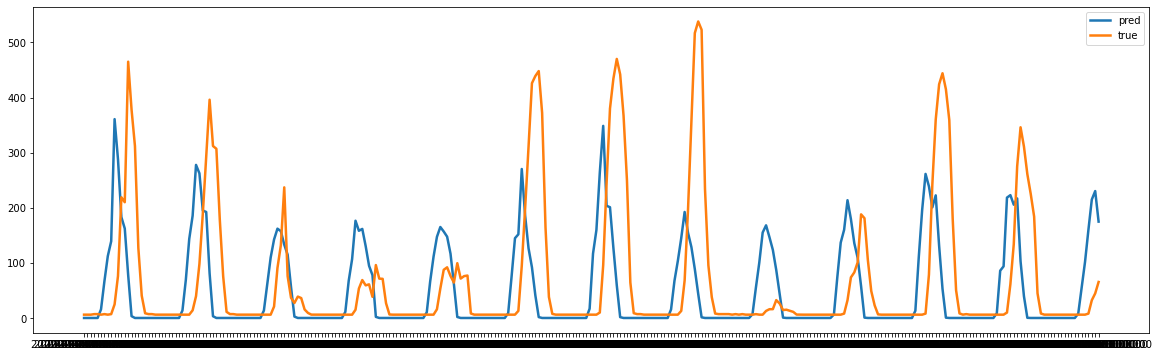

In [92]:
plt.plot(pred_[:300], label = 'pred')
plt.plot(true[:300], label = 'true')
plt.legend()
plt.show()


In [ ]:
pred_with_neb = pred.to_numpy()*(1-0.51*np.power(nebulosity/100,6.42).flatten())